# Computer Vision

## Basic Setup

### Mounting google drive

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Installing Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp37-none-any.whl size=73269 sha256=afd62aae25061e1c0425734608b4b3993ebdd303f70eabc74c8f12acfcebfded
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rachitvaid","key":"20bc73376d67bc30ac859bea96b9d88c"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

### Installing tflearn

In [2]:
! pip install tflearn

     |████████████████████████████████| 112kB 5.5MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp37-none-any.whl size=127301 sha256=c763e3a21047258e0f3efa22da40c557fcffb6ac1c789b60d4e99ce4b2cd9d79
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


## Part 1

### Importing Data from Kaggle

In [ ]:
! kaggle competitions download -c 'plant-seedlings-classification'

 99% 1.67G/1.69G [00:21<00:00, 69.2MB/s]
100% 1.69G/1.69G [00:21<00:00, 83.0MB/s]


In [ ]:
# Unzip the data to new directory
! unzip plant-seedlings-classification.zip -d plant-seedlings-classification

Streaming output truncated to the last 5000 lines.
  inflating: plant-seedlings-classification/test/ad12382d4.png  
  inflating: plant-seedlings-classification/test/adb7a032c.png  
  inflating: plant-seedlings-classification/test/ae90f2827.png  
  inflating: plant-seedlings-classification/test/aecfaed64.png  
  inflating: plant-seedlings-classification/test/aee6fa3df.png  
  inflating: plant-seedlings-classification/test/af45e222a.png  
  inflating: plant-seedlings-classification/test/afa446484.png  
  inflating: plant-seedlings-classification/test/afcf6abd5.png  
  inflating: plant-seedlings-classification/test/b026bf8ca.png  
  inflating: plant-seedlings-classification/test/b03397525.png  
  inflating: plant-seedlings-classification/test/b0acaff4a.png  
  inflating: plant-seedlings-classification/test/b130a0632.png  
  inflating: plant-seedlings-classification/test/b145ba9d4.png  
  inflating: plant-seedlings-classification/test/b1cd2a91e.png  
  inflating: plant-seedlings-classifica

In [ ]:
cd plant-seedlings-classification/

/content/plant-seedlings-classification


In [ ]:
#Removing files not required
rm sample_submission.csv

In [ ]:
rm '/content/plant-seedlings-classification.zip'

In [4]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, Input, Lambda
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob
from tensorflow.keras.applications import VGG16

### Data analysis and Image Load

                     Category  Count
0                 Black-grass    263
1             Shepherds Purse    231
2                     Fat Hen    475
3            Common Chickweed    611
4           Scentless Mayweed    516
5                    Cleavers    287
6                Common wheat    221
7                    Charlock    390
8                  Sugar beet    385
9            Loose Silky-bent    654
10                      Maize    221
11  Small-flowered Cranesbill    496


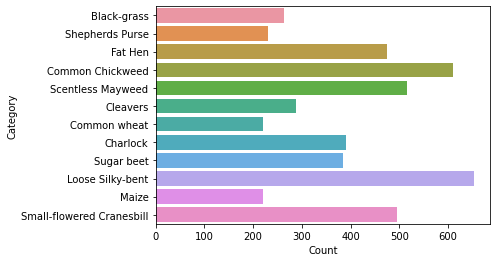

In [ ]:
## Displaying data in train folder based on class
pathh = "/content/plant-seedlings-classification/train/"

classes= []
sample_counts= []

for f in os.listdir(pathh):
    train_class_path= os.path.join(pathh, f)
    if os.path.isdir(train_class_path):
        classes.append(f)
        sample_counts.append(len(os.listdir(train_class_path)))
# Creating a dataframe for prediction in future
df=pd.DataFrame()
df['Category']=classes
df['Count']=sample_counts
print(df)
sns.barplot(y=df.Category, x=df.Count)

plt.show()
# Deleting variables not required to save RAM
del classes,sample_counts,train_class_path
df.drop(columns='Count', inplace=True)

Observations from the above graph:
- Data is unevenly distributed amongst samples
- Loose Silky-bent has the highest count of samples at 654
- Common wheat and Maize has the lowest count of samples at 221
- It is not a large dataset based on count

In [ ]:
#Creating the data for the training
X=[]
Y=[]
img_size=128        #choice of image size chosen
CATEGORIES = os.listdir(pathh)
def createTrainingData():
    for catg in CATEGORIES:
      PATH = os.path.join(pathh,catg)
      class_num = CATEGORIES.index(catg)
      print(catg,'-',class_num)
      for img in os.listdir(PATH):
        image = os.path.join(PATH, img)
        image = cv2.imread(image, cv2.IMREAD_ANYCOLOR)
        image = cv2.resize(image , (img_size, img_size))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        X.append(image)
        Y.append(class_num)
        X.append(cv2.flip(image,-1))
        Y.append(class_num)


Following steps performed on image data:
- get the COLORED image
- resize image to required size
- convert the colours
 - cv2 reads image in the format BGR. we change the color format so that we can view the image with original colors.
- add image and its corresponding class to the training set
- invert the image
  - This is done to increase the number of samples
- add the inverted image and its corresponding class to the training set

In [ ]:
# Call the function to create train set
createTrainingData()

Black-grass - 0
Shepherds Purse - 1
Fat Hen - 2
Common Chickweed - 3
Scentless Mayweed - 4
Cleavers - 5
Common wheat - 6
Charlock - 7
Sugar beet - 8
Loose Silky-bent - 9
Maize - 10
Small-flowered Cranesbill - 11


In [ ]:
## Print the sample size
print(len(X))
print(len(Y))

9500
9500


In [ ]:
# Get the pixelated value array for each image
X = np.array(X)/255
X.shape

(9500, 128, 128, 3)

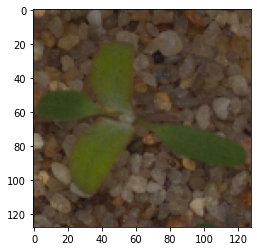

In [ ]:
# Display a random image
plt.imshow(X[1500])

In [ ]:
## flatten the image set array to train the model
X=X.reshape(len(X),-1)
print(X.shape)

(9500, 49152)


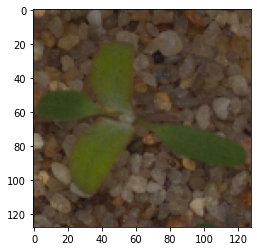

In [ ]:
# verify that the same image is displayed after reshaping the array
plt.imshow(X[1500].reshape(img_size, img_size,3))

### Working with Models

In [ ]:
## Split the dataset into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 20)
# delete original dataset as it is not required now.
del X
del Y

#### 1. Supervised learning model

In [ ]:
## fit the training data on decision tree classifier
dtcmodel = dt(random_state=20).fit(X_train,Y_train)

# Check the accuracy score
dtcmodel.score(X_test,Y_test)

0.3042105263157895

<u>Supervised Learning model:</u>
- We use decision tree as the supervised learning model
- The default model hyperparameters are used.
- As expected, the train accuracy for supervised learning model is quite low.

#### 2. Neural Network

In [ ]:
## One hot encoding the target classes
print("Value before encoding:", Y_train[10])
Y_train = to_categorical(Y_train, num_classes=12)
Y_test = to_categorical(Y_test, num_classes=12)
print("y_train shape:", Y_train.shape)
print(" y_train One hot encoded value:", Y_train[10])

Value before encoding: 6
y_train shape: (7600, 12)
 y_train One hot encoded value: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
# Creating a neural network model
model = Sequential()
## Adding layers
model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],), kernel_initializer='uniform'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(12, activation='softmax'))

## Adding optimiser
adam = optimizers.Adam()

# Compiling model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
# Fitting the model on train set
model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_split = 0.2)

# Evalauting the model accuracy on test set
model.evaluate(X_test,Y_test)

Epoch 1/50
95/95 [==============================] - 32s 327ms/step - loss: 7.4981 - accuracy: 0.1047 - val_loss: 2.3199 - val_accuracy: 0.1776
Epoch 2/50
95/95 [==============================] - 30s 320ms/step - loss: 2.3071 - accuracy: 0.1857 - val_loss: 2.1166 - val_accuracy: 0.2526
Epoch 3/50
95/95 [==============================] - 31s 322ms/step - loss: 2.1476 - accuracy: 0.2346 - val_loss: 2.0586 - val_accuracy: 0.2704
Epoch 4/50
95/95 [==============================] - 31s 324ms/step - loss: 2.0517 - accuracy: 0.2537 - val_loss: 1.9135 - val_accuracy: 0.3105
Epoch 5/50
95/95 [==============================] - 31s 323ms/step - loss: 1.9563 - accuracy: 0.2709 - val_loss: 1.8138 - val_accuracy: 0.3507
Epoch 6/50
95/95 [==============================] - 31s 322ms/step - loss: 1.8810 - accuracy: 0.3232 - val_loss: 2.0030 - val_accuracy: 0.2553
Epoch 7/50
95/95 [==============================] - 31s 323ms/step - loss: 1.7929 - accuracy: 0.3420 - val_loss: 1.8123 - val_accuracy: 0.3342

[1.5411542654037476, 0.5642105340957642]

In [ ]:
## Displaying the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              50332672  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 12)                6156      
Total params: 51,126,284
Trainable params: 51,126,284
Non-trainable params: 0
_________________________________________________________________


<u>Neural Network:</u>
- We create a sequential model with the following layers:
  - 3 hidden dense layers with 1024, 512 and 512 nodes using relu activation function
  - one output dense layer with 12 nodes for 12 target values using softmax activation function
  - one dropout layer with 30% dropout ratio
- The model is compiled with categorical_crossentropy loss function and adam optimiser
- After 50 epoch, the model train accuracy is around 75% and validation accuracy around 50%
- The model scores 56% on the test set, which is nearly double the accuracy of supervised learning
- The significant inprovement in accuracy shows how Neural networks are better than traditional supervised learning algorithms.

#### 3. Convolutional Neural Network

In [ ]:
## Reshaping the test and train array into a 4D array for CNN
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 3)
X_test = X_test.reshape(X_test.shape[0], img_size, img_size, 3)
image_shape = (img_size, img_size, 3)

def convmodel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=image_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(12, activation='softmax'))
    
    return model
    
    ## Adding optimiser
adam = optimizers.Adam()
    ## Calling the craete model function
cnn = convmodel()
    ## Compiling the model
cnn.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
#Saving the best model using model checkpoint callback
model_checkpoint_plant = ModelCheckpoint('plant_classifier.h5',
                                   save_best_only=True,
                                   monitor='val_accuracy',
                                   mode='max',
                                   verbose = 1)

In [ ]:
# Fit the model on train data and save the model with best validation accuracy
cnn.fit(X_train, Y_train, batch_size=100, epochs=10, verbose=1,validation_split = 0.2,callbacks = [model_checkpoint_plant])

## Evaluate the model on test data
cnn.evaluate(X_test, Y_test)

Epoch 1/10
61/61 [==============================] - 435s 7s/step - loss: 2.4215 - accuracy: 0.1521 - val_loss: 1.7061 - val_accuracy: 0.3895

Epoch 00001: val_accuracy improved from -inf to 0.38947, saving model to plant_classifier.h5
Epoch 2/10
61/61 [==============================] - 432s 7s/step - loss: 1.6345 - accuracy: 0.4041 - val_loss: 1.4297 - val_accuracy: 0.4961

Epoch 00002: val_accuracy improved from 0.38947 to 0.49605, saving model to plant_classifier.h5
Epoch 3/10
61/61 [==============================] - 443s 7s/step - loss: 1.2696 - accuracy: 0.5626 - val_loss: 0.9850 - val_accuracy: 0.6671

Epoch 00003: val_accuracy improved from 0.49605 to 0.66711, saving model to plant_classifier.h5
Epoch 4/10
61/61 [==============================] - 442s 7s/step - loss: 0.9135 - accuracy: 0.6840 - val_loss: 0.8249 - val_accuracy: 0.7105

Epoch 00004: val_accuracy improved from 0.66711 to 0.71053, saving model to plant_classifier.h5
Epoch 5/10
61/61 [==============================] -

[0.6006689667701721, 0.8178947567939758]

In [ ]:
## Displaying the model summary
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

<u>Convolutional Neural Network</u>
- We create a sequential model with the following layers:
  - 3 sets of 2 convolutional, one max pooling and one dropout layer followed by a flatten layer
  - 2 hidden dense layers with 512 and 512 nodes
  - The layers use relu activation function
  - One output dense layer with 12 nodes for 12 target values using softmax activation function
  - The three dropout layers have 25% dropout ratio while the last one has 30% dropout ratio
- The model is compiled with categorical_crossentropy loss function and adam optimiser
- After 10 epoch, the model train accuracy is around 90% and validation accuracy around 80%
- The model scores 81% on the test set, which is nearly a 30% improvement on neural network
- The significant inprovement in accuracy shows how Convolutional Neural networks are better than Neural networks which are in turn better than traditional supervised learning algorithms.

The trained cnn model is saved as plant_classifier.h5 as it is the best performing model

### Image Prediction

In [ ]:
## Uploading the image to be predicted.
files.upload()

Saving Predict.png to Predict.png


{'Predict.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02B\x00\x00\x02B\x08\x02\x00\x00\x00\xa3\xc5?W\x00\x01\x00\x00IDATx\x9cL\xfdI\x92,I\x92%\x08>\x1c\x88\x88YD\xf5\x9b\x99{Tdu\x1d\xa4\xcf\xd0W\xe8\xc37\xe4\xa2\x87\x82\x8c\x0c\x0f7\xfb\xaa"\xccL\x84C/\x90\xbfg\x01\xf8\xc2|aj"\xc2\xc4H\x88oB\xfa\x7f\xfe?\xfe\xef\xac\xd2\xfaH\xa2y-fi\xad\xad9E\x04 \x00\x002\x13\x04\x10eD\x02\x00"\x81D\xb8\x87-[\x93\x01\x10(\t\x84e&\xbd[\xc4\xb2\xb8\xae9\xe7\xf2\x88\x04\x98\x19\x80\xbb1\x08\x99\x0cB""H8\x89\xdc\xbd\x8d\x9e\x80\x99#AI\x19\x89Lb\x16\xe6\xa6\x92\xe16\x8f\x1f\xbf\xfdF\x0c\x15n\xadg8\x11\x89\x8a\xfb\x8a\xb0\x08c\x96y\xcd\xb5,\x9c\xdca\xe6\xd7\xb5z\xeb\xad\xb5\xfd\xb9\x7f\xbf\xbeH\x98\x88\xdc\x83Y\x90x\xbf\x8f}\x7fF\x86\x08\xb3\xc8\xd8\x07\x8b\x98[D\x00\x84HJB}u\xa4\xad\xb9\xed\xa3oCT\xb57\x0f\x17&\x16\x16\x11d\xdayqBE\xd6<\xb5\xd3\xf6\xd8TI\x84\t@"A\xc4\x9a\x89$\n\x80X \r f\x110<|\xaeL\xb41X\xc53\xcc\xd6\\+#\xcd\x16"\xdd\x9d@\xda\xbb\xf6\x91\xc0y\x9eL\xd0\xd6\x12\x11\x19,\xe2fa\x9e\x

In [ ]:
## Formatting image to be predicted
p_image = cv2.imread('Predict.png',cv2.IMREAD_ANYCOLOR)
p_image = cv2.resize(p_image , (Img_size, Img_size))
p_image = cv2.cvtColor(p_image, cv2.COLOR_BGR2RGB)

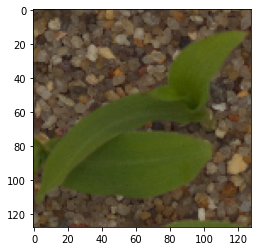

In [ ]:
## Displaying the image to be predicted
plt.imshow(p_image)

In [ ]:
## Displaying image shape
p_image.shape

(128, 128, 3)

In [ ]:
## Reshaping image data to 4D array
p_image = np.reshape(p_image,[1,img_size,img_size,3])

In [ ]:
## Getting the predicted value
col_val=np.argmax(cnn.predict(p_image),axis=1)

In [ ]:
## Displaying the predicted class name based on predicted index
df.iloc[col_val]

Category
10    Maize

The above image is predicted as belonging to class "Maize"

In [ ]:
## loading the saved model to confirm prediction
loaded_cnn=load_model('plant_classifier.h5')

In [ ]:
## Predicting using the saved model
col_val=np.argmax(loaded_cnn.predict(p_image),axis=1)
df.iloc[col_val]

Category
10    Maize

The predicted value of "Maize" validates the saved model is working correctly.

## Part 2

<i>Why CNN out performs neural networks which in turn out perform supervised learning
models when it comes to image classification:</i>
- <b><u>Convolutional Neural Networks:</b></u>
  - CNNs are better able to extract important features of images and learn from previous layers compared to neural networks.
  - CNNs are better able to identify spatial patterns compared to neural networks.
  - The total trainable parameters in CNN are way less compared to fully connected NN due to shared weights.
  - The ability to use pre-trained models instead of building from scratch also acts as an advantage of CNN.
  - CNN considers the context/shared information in the small neighborhoods making them most suitable for image classification

- <b><u>Neural Networks:</b></u> 
  - Neural networks are capable of handling larger amounts of data compared to traditional machine learning algorithms. 
  - More the data that is fed into the network, better are the weights trained and more accurate are the predictions made by the model.
  - Neural netwroks introduce non-linearity in the data with the help of activation functions. This helps in better feature extraction.
  - The addition of hidden layers in neural networks increases the model complexity and helps avoid overfitting.

- <b><u>Supervised learning aglorithms:</b></u> 
  - Huge size of dataset containing the pixel values of images makes these algorithms perform poorly.
  - Feature exctraction in image classification needs to be done manually to extract meaningful info, which further make supervised algorthims a poor choice when it comes to image classification

## Part 3

In [2]:
## getting the uploaded zip file from drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/car_images.zip'

In [3]:
from zipfile import ZipFile
with ZipFile(zip_path, 'r') as zip:
  zip.extractall()

In [6]:
image_path = '/content/car_images/*'
csv_path = '/content/Cars.csv'
cars = pd.read_csv(csv_path)
index = list(cars['ID'])
cars.index = cars['ID'].values
cars

ID       Brand    Model         Type  Launch Year   Color
1    1        Audi       A5        Coupe         2004   White
2    2      Acura       TSX        Sedan         2003   Black
3    3       Dodge   Dakota        Truck         1986  Maroon
4    4     Hyundai   Sonata        Sedan         1989  Maroon
5    5        Ford  Unknown        Truck         1980   White
6    6         Geo    Metro  Convertible         1989     Red
7    7       Dodge  Journey          SUV         2007    Blue
8    8       Dodge  Charger        Sedan         1964     Red
9    9  Mitsubishi   Lancer        Sedan         1973    Grey
10  10   Chevrolet   Blazer          SUV         2019    Grey
11  11       Buick   Verano        Sedan         2010   White
12  12      Toyota  Sequoia          SUV         2004    Grey
13  13     Hyundai  Elantra    Hatchback         1990   White
14  14       Dodge  Caravan      Minivan         1983   White
15  15       Volvo      C30    Hatchback         2006  Orange

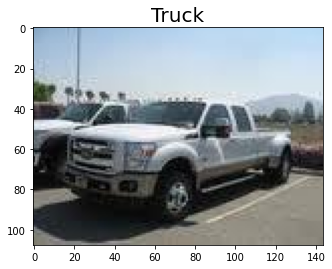

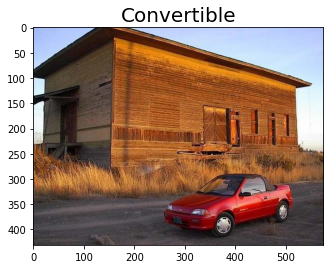

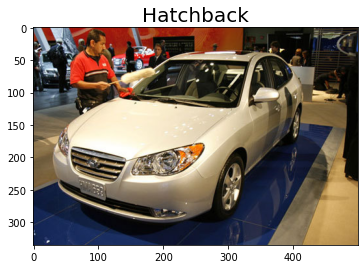

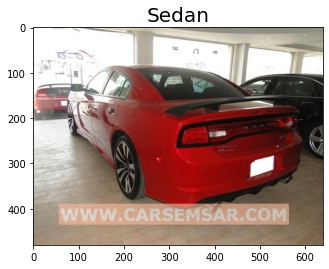

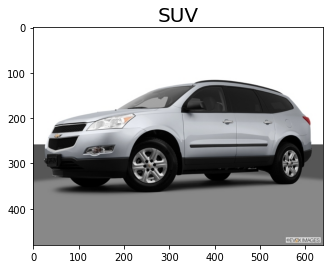

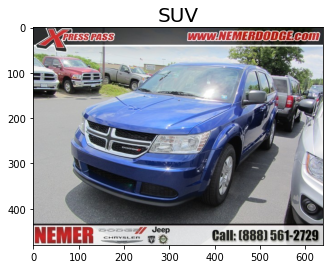

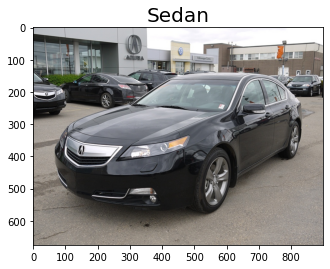

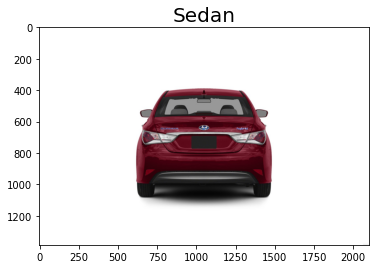

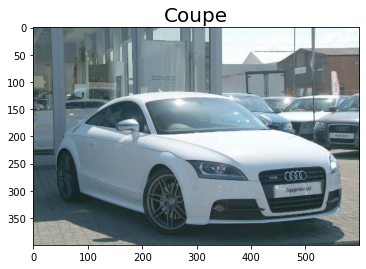

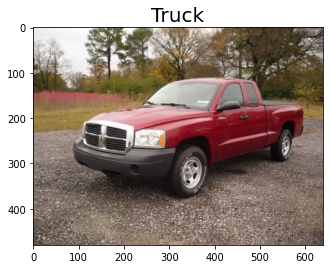

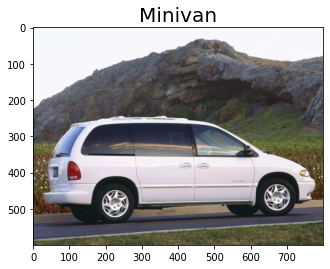

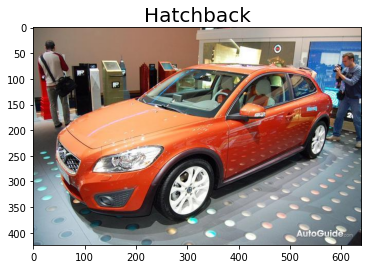

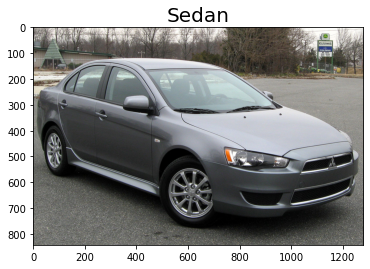

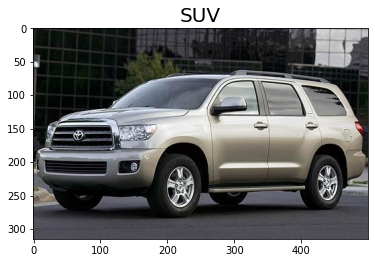

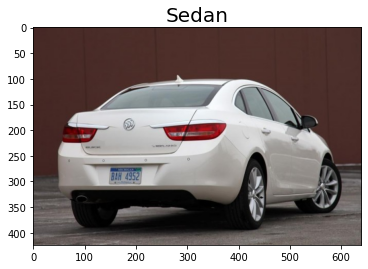

In [12]:
for file in glob(image_path):
  plt.figure()
  car = cv2.imread(file)
  car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB) 
  label = int(file[-9:-4])
  for x in cars['ID']:
    if x == label:
      ## Considering type as label
      new_label =  cars['Type'][x]

  plt.title(new_label,fontsize = 20)
  plt.imshow(car)

## Part 4







### Importing data from tflearn

In [3]:
from tflearn.datasets import oxflower17 as oxf

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
X, Y = oxf.load_data()

100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


### Data Visualization

In [5]:
## Displaying the shape of data
print(X.shape)
print(Y.shape)

(1360, 224, 224, 3)
(1360,)


In [6]:
Img_size=X.shape[1]
print(Img_size)

224


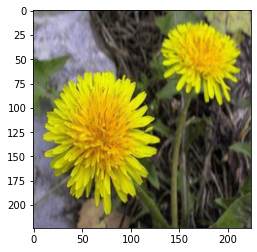

In [ ]:
# Displaying a random image
plt.imshow(X[50])

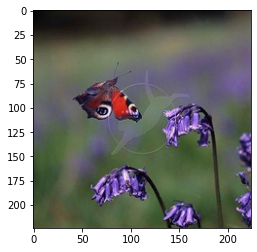

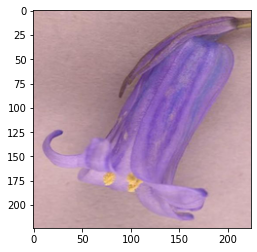

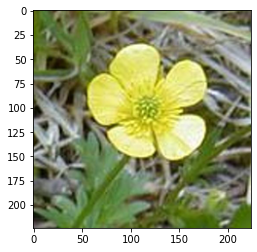

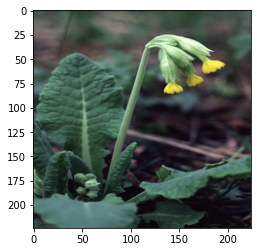

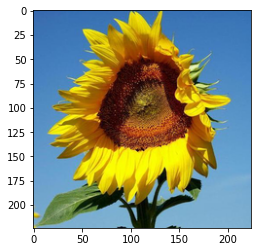

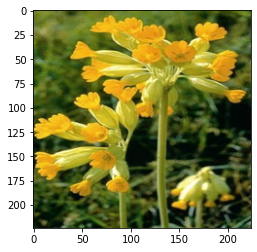

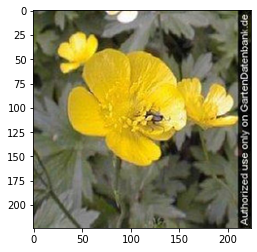

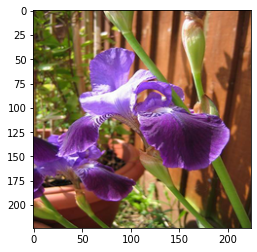

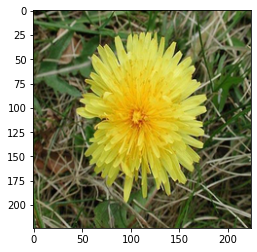

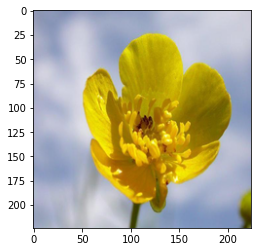

In [ ]:
#Displaying images
for i in range(25,45,2):
  img = X[i]
  plt.figure(i)
  plt.imshow(img)

In [ ]:
  ## Displaying classes
  for i in range(25,45,2):
    y = Y[i]
    print('Class of image {} is {}'.format(i,y))

Class of image 25 is 10
Class of image 27 is 10
Class of image 29 is 6
Class of image 31 is 5
Class of image 33 is 16
Class of image 35 is 5
Class of image 37 is 6
Class of image 39 is 12
Class of image 41 is 4
Class of image 43 is 6


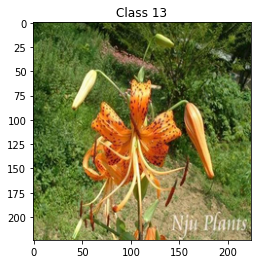

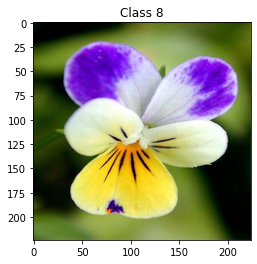

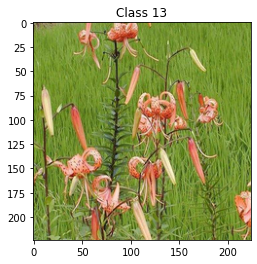

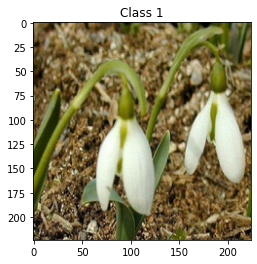

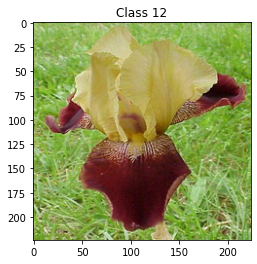

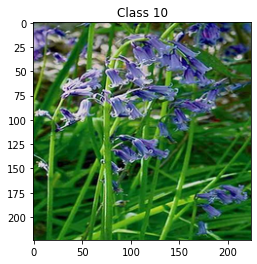

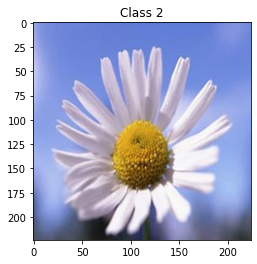

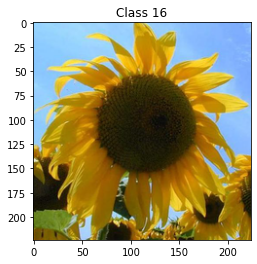

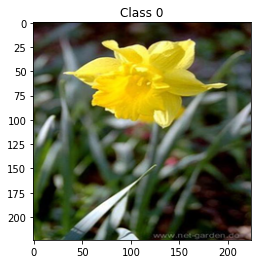

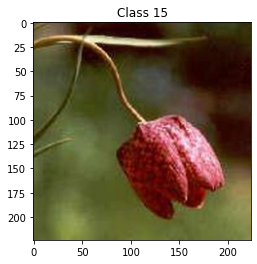

In [ ]:
## Displaying images and their labels
for i in range(100,130,3):
    img = X[i]
    plt.figure(i)
    label = 'Class ' + str(Y[i])
    plt.title(label)
    plt.imshow(img)

In [ ]:
## Choosing a random image for filters
path = '/content/17flowers/jpg/'
import os
import random 
files=os.listdir(path)
d=random.choice(files)
folder_path = path + d
images = os.listdir(folder_path)
pic = random.choice(images)
image_path = folder_path + '/' + pic
image_path

'/content/17flowers/jpg/7/image_0566.jpg'

Original image:


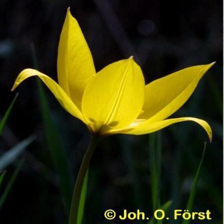

In [ ]:
# Applying different filters 
from PIL import Image
from PIL import ImageFilter
image = Image.open(image_path)
img_size = X[0].shape[:2]
image = image.resize(img_size) 
print('Original image:')
image

Blurred image:


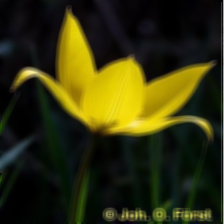

In [ ]:
print('Blurred image:')
image.filter(ImageFilter.BLUR)

Contour filter:


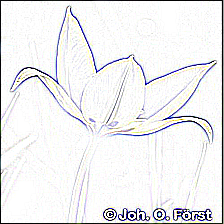

In [ ]:
print('Contour filter:')
image.filter(ImageFilter.CONTOUR)

Edge Enhance filter:


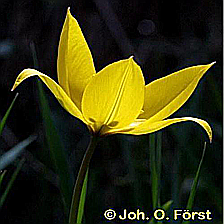

In [ ]:
print('Edge Enhance filter:')
image.filter(ImageFilter.EDGE_ENHANCE)

Find Edges filter:


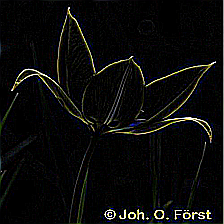

In [ ]:
print('Find Edges filter:')
image.filter(ImageFilter.FIND_EDGES)

Emboss filter:


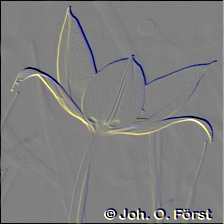

In [ ]:
print('Emboss filter:')
image.filter(ImageFilter.EMBOSS)

Smooth filter:


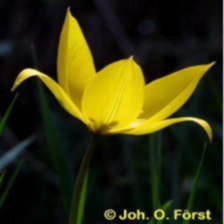

In [ ]:
print('Smooth filter:')
image.filter(ImageFilter.SMOOTH)

Sharpen filter:


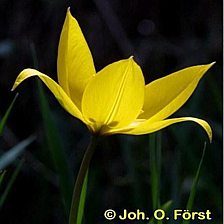

In [ ]:
print('Sharpen filter:')
image.filter(ImageFilter.SHARPEN)

In [ ]:
# Reshaping image array to be used in various models
X=X.reshape(len(X),-1)
print(X.shape)

(1360, 150528)


In [ ]:
# displaying number of classes
len(np.unique(Y))

17

### Working with Models

In [ ]:
## Splitting the data into train test set in 80:20 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 20)
del X
del Y

#### 1. Supervised learning model

In [ ]:
## fit the training data on decision tree classifier
dtcmodel = dt(random_state=20).fit(X_train,Y_train)

# Check the accuracy score
dtcmodel.score(X_test,Y_test)

0.29411764705882354

<u>Supervised Learning model:</u>
- We use decision tree as the supervised learning model
- The default model hyperparameters are used.
- As expected, the train accuracy for supervised learning model is quite low.

#### 2. Neural Network

In [ ]:
## One hot encoding the target class 
print("Value before encoding:", Y_train[10])
Y_train = to_categorical(Y_train, num_classes=17)
Y_test = to_categorical(Y_test, num_classes=17)
print("y_train shape:", Y_train.shape)
print("y_train One hot encoded value:", Y_train[10])

Value before encoding: 3
y_train shape: (1088, 17)
y_train One hot encoded value: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Creating a neural network model
model = Sequential()

model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],), kernel_initializer='uniform'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(17, activation='softmax'))

    ## Adding optimiser
adam = optimizers.Adam()

    # Compiling model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Fit the model
model.fit(X_train, Y_train, epochs=80, batch_size=87, validation_split = 0.2)


Train on 870 samples, validate on 218 samples
Epoch 1/80
870/870 [==============================] - ETA: 0s - loss: 55.0698 - acc: 0.0621

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


870/870 [==============================] - 28s 33ms/sample - loss: 55.0698 - acc: 0.0621 - val_loss: 19.7009 - val_acc: 0.0596
Epoch 2/80
870/870 [==============================] - 17s 20ms/sample - loss: 13.1251 - acc: 0.1184 - val_loss: 3.2810 - val_acc: 0.1651
Epoch 3/80
870/870 [==============================] - 16s 18ms/sample - loss: 3.9445 - acc: 0.1701 - val_loss: 2.5205 - val_acc: 0.1330
Epoch 4/80
870/870 [==============================] - 16s 18ms/sample - loss: 2.5592 - acc: 0.1552 - val_loss: 2.3153 - val_acc: 0.2294
Epoch 5/80
870/870 [==============================] - 16s 18ms/sample - loss: 2.3812 - acc: 0.2092 - val_loss: 2.3126 - val_acc: 0.2110
Epoch 6/80
870/870 [==============================] - 15s 18ms/sample - loss: 2.3760 - acc: 0.1805 - val_loss: 2.1996 - val_acc: 0.2385
Epoch 7/80
870/870 [==============================] - 16s 18ms/sample - loss: 2.3588 - acc: 0.2023 - val_loss: 2.2779 - val_acc: 0.1881
Epoch 8/80
870/870 [==============================] - 16

In [ ]:
## Evaluting the model on test set
model.evaluate(X_test,Y_test)

[2.4339599749621224, 0.44852942]

In [ ]:
# Displaying model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              154141696 
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 17)                8721      
Total params: 154,937,873
Trainable params: 154,937,873
Non-trainable params: 0
_________________________________________________________________


<u>Neural Network:</u>
- We create a sequential model with the following layers:
  - 3 hidden dense layers with 1024, 512 and 512 nodes using relu activation function
  - one output dense layer with 17 nodes for 17 target values using softmax activation function
  - one dropout layer with 30% dropout ratio
- The model is compiled with categorical_crossentropy loss function and adam optimiser
- After 80 epoch, the model train accuracy is around 75% and validation accuracy around 45%
- The model scores 44% on the test set.
- The inprovement in accuracy shows how Neural networks are better than traditional supervised learning algorithms.
- The low scores can be credited to the lack of data 

#### 3. Convolutional Neural Network

In [ ]:
## Reshaping the test and train array into a 4D array for CNN
X_train = X_train.reshape(X_train.shape[0], Img_size, Img_size, 3)
X_test = X_test.reshape(X_test.shape[0], Img_size, Img_size, 3)
image_shape = (Img_size, Img_size, 3)

In [ ]:
### Creating a CNN network
def convmodel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=image_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(17, activation='softmax'))
    
    return model

cnn = convmodel()

## Adding optimiser
adam = optimizers.Adam()

# Compiling the model
cnn.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
# Displaying the summary
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 28, 28, 64)       

In [ ]:
#Saving the best model using model checkpoint callback
model_checkpoint_oxf = ModelCheckpoint('oxf_classifier.h5',
                                   save_best_only=True,
                                   monitor='val_acc',
                                   mode='max',
                                   verbose = 1)

In [ ]:
## Fit the model on train set
cnn.fit(X_train, Y_train, batch_size=87, epochs=20,validation_split = 0.2,callbacks = [model_checkpoint_oxf]) 

Train on 870 samples, validate on 218 samples
Epoch 1/20
870/870 [==============================] - ETA: 0s - loss: 4.1948 - acc: 0.0851

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_acc improved from -inf to 0.07798, saving model to oxf_classifier.h5
870/870 [==============================] - 63s 72ms/sample - loss: 4.1948 - acc: 0.0851 - val_loss: 2.8126 - val_acc: 0.0780
Epoch 2/20
870/870 [==============================] - ETA: 0s - loss: 2.7677 - acc: 0.1149
Epoch 00002: val_acc improved from 0.07798 to 0.14679, saving model to oxf_classifier.h5
870/870 [==============================] - 61s 70ms/sample - loss: 2.7677 - acc: 0.1149 - val_loss: 2.6775 - val_acc: 0.1468
Epoch 3/20
870/870 [==============================] - ETA: 0s - loss: 2.3847 - acc: 0.1920
Epoch 00003: val_acc improved from 0.14679 to 0.16972, saving model to oxf_classifier.h5
870/870 [==============================] - 60s 69ms/sample - loss: 2.3847 - acc: 0.1920 - val_loss: 2.4102 - val_acc: 0.1697
Epoch 4/20
870/870 [==============================] - ETA: 0s - loss: 2.0898 - acc: 0.2586
Epoch 00004: val_acc improved from 0.16972 to 0.26147, saving model to oxf_classifier.h

In [ ]:
## Evaluating the trained model on test set
cnn.evaluate(X_test, Y_test)

[1.6661157818401562, 0.5882353]

In [ ]:
## Loading the saved model to evaluate
saved_oxf=load_model('oxf_classifier.h5')
saved_oxf.evaluate(X_test, Y_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[1.3608374455395866, 0.6066176]

<u>Convolutional Neural Network</u>
- We create a sequential model with the following layers:
  - 3 sets of one convolutional and one max pooling layer followed by a flatten layer
  - one dropout layer with 20% dropout ratio
  - 3 hidden dense layers with 1024, 512 and 512 nodes
  - The layers use relu activation function
  - One output dense layer with 17 nodes for 17 target values using softmax activation function
  - The last dropout layer has 30% dropout ratio
- The model is compiled with categorical_crossentropy loss function and adam optimiser
- After 20 epoch, the model train accuracy is around 99% and validation accuracy around 50% denoting a slightly overfit model
- The model scores around 60% on the test set, which is nearly a 30% improvement on neural network
- The significant inprovement in accuracy shows how Convolutional Neural networks are better than Neural networks which are in turn better than traditional supervised learning algorithms.

The trained cnn model is saved as oxf_classifier.h5 as it is the best performing model of the three.

#### 4. Transfer Learning

In [ ]:
## Importing a pretrained model
pretrained_model=VGG16(input_shape = (Img_size, Img_size, 3), 
                        include_top = False, 
                        weights ='imagenet')

## Setting layers as non trainable
for layer in pretrained_model.layers:
     layer.trainable = False
     
## Displaying model summary
pretrained_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
## Modifying the pretrained model with new last layers
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output
## Adding new layers
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)                  
x = layers.Dense(17, activation='softmax')(x)           
## Updated model
vgg_model = Model(pretrained_model.input, x) 

## Compiling the tl model
vgg_model.compile(optimizer ='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
##  Creating model checkpoint to save model
model_checkpoint_tl = ModelCheckpoint('flower_tl_classifier.h5',
                                   save_best_only=True,
                                   monitor='val_acc',
                                   mode='max',
                                   verbose = 1)

In [ ]:
## Fit the model on train data
vgg_model.fit(X_train, Y_train, batch_size=64, epochs=10, validation_split = 0.2,  callbacks=[model_checkpoint_tl])

Train on 870 samples, validate on 218 samples
Epoch 1/10
870/870 [==============================] - ETA: 0s - loss: 3.3581 - acc: 0.2103 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_acc improved from -inf to 0.48624, saving model to flower_tl_classifier.h5
870/870 [==============================] - 479s 550ms/sample - loss: 3.3581 - acc: 0.2103 - val_loss: 1.6957 - val_acc: 0.4862
Epoch 2/10
870/870 [==============================] - ETA: 0s - loss: 1.0466 - acc: 0.6977 
Epoch 00002: val_acc improved from 0.48624 to 0.74771, saving model to flower_tl_classifier.h5
870/870 [==============================] - 481s 553ms/sample - loss: 1.0466 - acc: 0.6977 - val_loss: 0.8740 - val_acc: 0.7477
Epoch 3/10
870/870 [==============================] - ETA: 0s - loss: 0.4742 - acc: 0.8563 
Epoch 00003: val_acc improved from 0.74771 to 0.76606, saving model to flower_tl_classifier.h5
870/870 [==============================] - 481s 553ms/sample - loss: 0.4742 - acc: 0.8563 - val_loss: 0.7534 - val_acc: 0.7661
Epoch 4/10
870/870 [==============================] - ETA: 0s - loss: 0.2290 - acc: 0.9333 
Epoch 00004: val_acc improved from 0.76606 to 0.78440, savin

In [ ]:
## Evaluating the trained model on test data
vgg_model.evaluate(X_test, Y_test)

[0.5461721157326418, 0.83455884]

In [ ]:
## Loading the saved model to verify
saved_tl=load_model('flower_tl_classifier.h5')

## Evaluating on test data to validate proper functioning
saved_tl.evaluate(X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[0.649377752752865, 0.8088235]

In [ ]:
!rm oxf_classifier.h5

<u>Transfer learning</u>
- We update the already trained VGG16 model by adding the following layers:
  - A flatten layer
  - One dropout layer with 20% dropout ratio
  - 2 hidden dense layers with 512 and 512 nodes
  - The layers use relu activation function
  - One output dense layer with 17 nodes for 17 target values using softmax activation function
- The model is compiled with categorical_crossentropy loss function and adam optimiser
- After 10 epoch, the model train accuracy is approximately 100% and validation accuracy is nearly 85%.
- The model scores around 80% on the test set, which is nearly a 30% improvement on Convolutional neural network created from scratch.
- The significant inprovement in accuracy shows how Convolutional Neural networks using pretrained models, that is, using transfer learning,can fit the data better and thus are better than CNN craeted from scratch which is in turn better than Neural networks which are in turn better than traditional supervised learning algorithms.

The trained cnn model is saved as flower_tl_classifier.h5 as it is the best performing model of the four.
The previously saved model is deleted to free RAM

In [ ]:
## Saving the best trained model to drive
cp '/content/flower_tl_classifier.h5' '/content/gdrive/MyDrive/Colab Notebooks/Rachit'

- The above operations clearly show that using the pretrained model and adding on to it, improves the functioning of the model drastically, giving higher accuracies than that achieved by CNN networks created from scratch.

- This is due to the fact that in a pretrained model, the weights of the network are already trained using huge amount of data and this learning can be transferred to create newer models based on this.


### Image Classifier GUI

In [ ]:
# Image Classifier using Tkinter 

## Importing default libraries
import os
import matplotlib as mpl
if os.environ.get('DISPLAY','') == '':
    mpl.use('Agg')
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog
import re
import numpy as np
from tensorflow.keras.models import load_model
import cv2

# Setting default image size
Img_size=224

## Creating a new Window
win=tk.Tk()
win.title('Classifier GUI')

## Creating a name field displaying input file name 
Name= ttk.Label(win, text="Upload File")
Name.grid(row=0,column=0, sticky=tk.W)

## Upload button to fetch file from system
def UploadAction(event=None):
    global filename
    filename = filedialog.askopenfilename()

button = tk.Button(win, text='Upload', command=UploadAction)
button.grid(row=0,column=1)

## Import data function to read and format image
def Import_data():
    global img
    img = cv2.imread(filename)
    img = cv2.resize(img , (Img_size, Img_size))
    img = np.reshape(img,[1,Img_size,Img_size,3])

Import_button=ttk.Button(win,text="Import Image", command = Import_data)
Import_button.grid(row=0,column=2)

## Label saying Prediction
Result= ttk.Label(win, text="Prediction")
Result.grid(row=1,column=0, sticky=tk.W)

## Predicting class using saved model
def predict_result():
    global res
    model=load_model('/content/gdrive/MyDrive/Colab Notebooks/Rachit/flower_tl_classifier.h5')
    res=np.argmax(model.predict(img),axis=1)
    value_op=ttk.Entry(win,width=16)
    value_op.grid(row=1,column=2)
    value_op.insert(1,str(res))

predict_button=ttk.Button(win,text="Predict class", command = predict_result)
predict_button.grid(row=1,column=1)
## Closing the mainloop to run till user intervention
win.mainloop()


When the above code is run in Jupyter Notebook locally (doesn't work on colab), the GUI expects the user to click on upload to select image from computer, click Import image to import and format image and then press Predict class to get the predicted class.

When Flower.jpg was uploaded, Class 2 was predicted by the model.

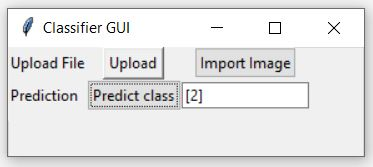

## Part 5

*Strategy to maintain and support the AIML image classifier after it in production*


*   Monitor the model for errors, crashes and latency
*   Monitor performance accuracy Range
*   Monitor performance metrics of the deployed model over time
*   Make sure enviromental variables and parameters hold and do not overload
*   Ensure ample storage space for growing Model size as it learns
*   When transitioning from training to production, manage high probability of misclassification.
*   After the model has run on production data for a while, use the trained model to develop better models using transfer learning.
